Import the necessary packages.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.datasets import make_moons

In [68]:
import warnings
warnings.filterwarnings('ignore')

Load the dataset.

In [69]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [70]:
X.shape

(500, 2)

In [71]:
type(X)

numpy.ndarray

In [72]:
X[:5]

array([[ 0.83103915, -0.25874875],
       [ 1.18506381,  0.92038714],
       [ 1.16402213, -0.45552558],
       [-0.0236556 ,  1.08628844],
       [ 0.48050273,  1.50942444]])

In [73]:
y[:5]

array([1, 0, 1, 0, 0], dtype=int64)

In [74]:
np.max(X[:,0])

2.7989983478330194

In [75]:
np.max(X[:,1])

1.7659487983707112

In [76]:
np.min(X[:,0])

-1.7408522272299314

In [77]:
np.min(X[:,1])

-1.2463476136208174

Split the dataset into training nad testing set.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [79]:
X_train.shape

(375, 2)

In [80]:
X_test.shape

(125, 2)

Implement Grid Search to compare the performance of different models.

In [81]:
models = {
    'log_clf': LogisticRegression(),
    'rnd_clf': RandomForestClassifier(),
    
    'svm_clf': SVC()
}

params = {
    'log_clf': { 'C':np.logspace(-3,3,7), 'penalty':["l1","l2"] },
    'rnd_clf': { 'n_estimators': [16, 32] },
    
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

In [82]:
for name, estimator in zip(models,params):

    clf = GridSearchCV(estimator = models[name], 
                       param_grid = params[estimator] ,
                       scoring = 'accuracy',
                       return_train_score = True)
    clf.fit(X_train, y_train)
    
best_estimator = clf.best_estimator_
print("best model: " + str(clf.best_estimator_))
print("best params: " + str(clf.best_params_))
print("best scores: " + str(clf.best_score_))
    

best model: SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
best params: {'C': 10, 'kernel': 'linear'}
best scores: 0.8426666666666666


Implement the K-Fold cross validation.

In [83]:
num_folds = 5


X_train_folds = []
y_train_folds = []

scores = []

X_train_folds = np.split(X_train,num_folds)
y_train_folds = np.split(y_train,num_folds)

for folds in range(num_folds):
    X_train_rows = np.concatenate([f for j,f in enumerate(X_train_folds) if j!=folds ])
    y_train_rows = np.concatenate([f for j,f in enumerate(y_train_folds) if j!=folds ])
    X_val_rows = X_train_folds[folds]
    y_val_rows = y_train_folds[folds]

    best_estimator.fit(X_train,y_train)
    y_pred = best_estimator.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

avg_score = np.sum(scores)/num_folds
print(avg_score)

0.8560000000000001


Compare the performance of few models individually and also comparing the performance after taking voting from all the other classifiers.

In [84]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [85]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


We found that the classification made after taking the votes from individual classifiers and then averaging their scores performs better and generalizes well.

Text(0, 0.5, 'Feature importance')

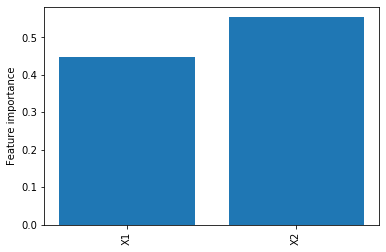

In [86]:
#only rnd_clf has feature importance attribute

importance = rnd_clf.feature_importances_
plt.bar(range(2), importance, tick_label = ['X1', 'X2'])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')

In [87]:

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Shows the decision boundary of different classifiers for the entire dataset, the training dataset and the testing dataset respectively.

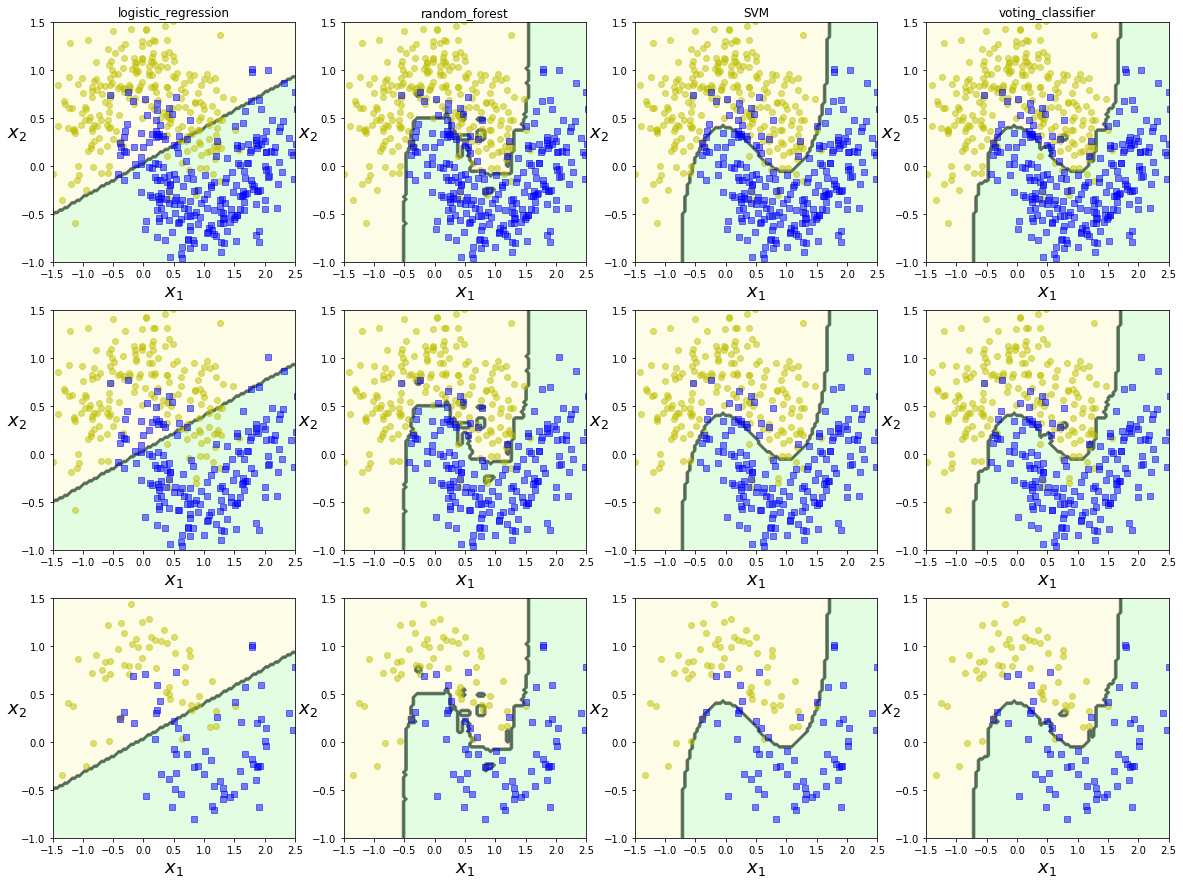

In [88]:
plt.figure(figsize=(20, 15))
classifiers = [log_clf, rnd_clf, svm_clf, voting_clf]
clas_map = ['logistic_regression', 'random_forest', 'SVM', 'voting_classifier']
Xx = [(X,y),(X_train,y_train),(X_test,y_test)]
n_rows = 4
n_cols = 3

count = 0
for i, xy in enumerate(Xx):
    X, y = xy 
    for idx, val in enumerate(classifiers):
        count += 1
        plt.subplot(n_cols,n_rows,count)
        plot_decision_boundary(val,X,y)
        for clasi in range(len(classifiers)):
            if(count==clasi+1):
                plt.title(clas_map[clasi])
plt.show()
 